In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control import oc_wc

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
points_bi = [[4.2, 3.5], [5.4, 3.5] ]

In [3]:
def gettarget(targetstate):
    target = np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
    target[0,0,:] = targetstate[0]
    target[0,1,:] = targetstate[1]

    return target

def setinit(initstate):
    wc.params["exc_init"] = np.array([[ initstate[0] ]])
    wc.params["inh_init"] = np.array([[ initstate[1] ]])

def decrease_step_compute():

    for pow in [-4, -5]:

        wc_controlled.step = 10**pow
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

def increase_step_compute():

    for pow in [-2, -1, 0, 2, 4]:

        wc_controlled.step = 10**pow
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200*(3 + pow))

    return

def get_values(results_dict, ip, w):
    results_dict["control"][ip] = wc_controlled.control.copy()
    results_dict["state"][ip] = wc_controlled.get_xs().copy()
    results_dict["cost"][ip] = wc_controlled.cost_history[-1]

    wc_controlled.w_2 = 0.
    wc_controlled.simulate_forward()
    results_dict["precision_cost"][ip] = wc_controlled.compute_total_cost()
    wc_controlled.w_2 = w

    ce = np.zeros((results_dict["control"][ip].shape))
    ce[0,0,:] = results_dict["control"][ip][0,0,:]
    results_dict["L_cost"][ip][0] = cost_functions.energy_cost(ce, 1., dt)
    ci = np.zeros((results_dict["control"][ip].shape))
    ci[0,1,:] = results_dict["control"][ip][0,1,:]
    results_dict["L_cost"][ip][1] = cost_functions.energy_cost(ci, 1., dt)

    return

def getmodel(t, w, results_dict, i):
    wc_controlled = oc_wc.OcWc(wc, target=t, w_p=1, w_2=w, print_array=[], precision_cost_interval=(int0,None), control_matrix=control_mat, precision_matrix=prec_mat)

    if type(results_dict["control"][i]) != type(None):
        print("use previous result")
        wc_controlled.control = results_dict["control"][i].copy()
        wc_controlled.update_input()
    wc_controlled.model.run()    

    return wc_controlled


In [4]:
n_points = len(points_bi)
file_array = []
for i in range(len(points_bi)):
    file_array.append('w2_' + str(i+1) + '.png')

results_w2_du = dict([
    ('cost_type', 'w2'),
    ('point', [None] * n_points),
    ('d', [None] * n_points),
    ('u', [None] * n_points),
    ("cost", [None] * n_points),
    ("initial_cost", [None] * n_points),
    ("precision_cost", [None] * n_points),
    ("L_cost", [np.zeros((2))] * n_points),
    ("control", [None] * n_points),
    ("state", [None] * n_points),
    ("filename", file_array)
    ])

def save(results_dict):
    filehandler = open("w2_du.pickle","wb")
    pickle.dump(results_dict,filehandler)
    filehandler.close()

In [5]:
wc = WCModel()
wc.params.sigma_ou = 0.
dt = 0.1
wc.params.dt = dt
duration = 500.
wc.params["duration"] = duration

wc.params.c_excinh = 2.
wc.params.c_inhexc = 16.
wc.params.c_inhinh = 1.

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
bi_control = zero_input.copy()
bi_control[0,:500] = -5.
bi_control[0,2500:3000] = +5.

for i in range(len(points_bi)):

    p = points_bi[i]
    results_w2_du['point'][i] = p

    wc.params["exc_ext"] = bi_control + p[0]
    wc.params["inh_ext"] = zero_input + p[1]
    wc.run()

    results_w2_du['d'][i] = [wc.exc[0,2000], wc.inh[0,2000]]
    results_w2_du['u'][i] = [wc.exc[0,-1], wc.inh[0,-1]]

    #plt.plot(wc.exc[0,:])
    #plt.show()

In [6]:
filehandler = open("w2_du.pickle","rb")
results_w2_du = pickle.load(filehandler)
filehandler.close()

In [28]:
int0 = 1800
w1 = 1.

control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.

prec_mat = np.zeros( (wc.params.N, len(wc.output_vars)) )
prec_mat[0,0] = 1.
prec_mat[0,1] = 1.

duration = 300.
wc.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)

for i in range(len(points_bi)):

    if i == 0:
        continue

    print("POINT ", i+1)

    p = points_bi[i]

    wc.params["exc_ext"] = zero_input + p[0]
    wc.params["inh_ext"] = zero_input + p[1]

    target = gettarget( results_w2_du['u'][i] )
    setinit( results_w2_du['d'][i] )

    #if type(results_w2_du["control"][i]) != type(None):
    #    continue

    #results_w2_du["control"][i] = None
        
    wc_controlled = getmodel(target, w1, results_w2_du, i)

    if False:
        wc_controlled.step = 1e-3
        wc_controlled.optimize(1)

        results_w2_du["initial_cost"][i] = wc_controlled.cost_history[0]

        wc_controlled.control[0,0,-300:-200] = 5.
        wc_controlled.update_input()

        wc_controlled.step = 1e-2
        wc_controlled.optimize(100)

        increase_step_compute()

        ce = wc_controlled.cost_history[-1]
        control_e = wc_controlled.control.copy()

        wc_controlled.control[0,0,:] = 0.
        wc_controlled.control[0,1,-300:-200] = -5.
        wc_controlled.update_input()

        wc_controlled.step = 1e-2
        wc_controlled.optimize(100)

        increase_step_compute()

        ci = wc_controlled.cost_history[-1]

        if ce <= ci:
            wc_controlled.control = control_e.copy()
            wc_controlled.update_input()

        wc_controlled.optimize(0)    
        get_values(results_w2_du, i, w1)    

    if False:
        wc_controlled.step = 10**(-18)
        wc_controlled.step_factor = 0.9
        wc_controlled.optimize(200)

        if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
            get_values(results_w2_du, i, w1)
            save(results_w2_du)
            print("get values")

        break


    for k in range(200):
        print(k)
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,:-10] = wc_controlled.control[0,:,10:]
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(0)

        decrease_step_compute()

        wc_controlled.step = 10**(-12)
        wc_controlled.optimize(100)

        wc_controlled.step = 10**(-14)
        wc_controlled.optimize(100)

        wc_controlled.step = 10**(-16)
        wc_controlled.optimize(100)

        if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
            get_values(results_w2_du, i, w1)
            save(results_w2_du)
        else: break

    for k in range(100):
        print(k)
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,:-1] = 1.05 * wc_controlled.control[0,:,1:]
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()
        wc_controlled.optimize(0)

        decrease_step_compute()

        wc_controlled.step = 10**(-12)
        wc_controlled.optimize(100)

        wc_controlled.step = 10**(-14)
        wc_controlled.optimize(100)

        wc_controlled.step = 10**(-16)
        wc_controlled.optimize(100)

        if results_w2_du["cost"][i] > wc_controlled.cost_history[-1]:
            get_values(results_w2_du, i, w1)
            save(results_w2_du)
        else: break

    save(results_w2_du)

POINT  2
use previous result
0
Compute control for a deterministic system
Cost in iteration 0: 0.7384783475664028
Final cost : 0.7384783475664028
Compute control for a deterministic system
Cost in iteration 0: 0.7384783475664028
Converged in iteration 1 with cost 0.7384783475664028 because of step counter
Final cost : 0.7384783475664028
Compute control for a deterministic system
Cost in iteration 0: 0.7384783475664028
Converged in iteration 1 with cost 0.7384783475664028 because of step counter
Final cost : 0.7384783475664028
Compute control for a deterministic system
Cost in iteration 0: 0.7384783475664028
Final cost : 0.7384783475664028
Compute control for a deterministic system
Cost in iteration 0: 0.7384783475664028
Final cost : 0.7384783475664028
Compute control for a deterministic system
Cost in iteration 0: 0.7384783475664028
Final cost : 0.7384783475664028
0
Compute control for a deterministic system
Cost in iteration 0: 0.8141723781919584
Final cost : 0.8141723781919584
Comput

POINT  1
2.870294592999063 14.339490966391995


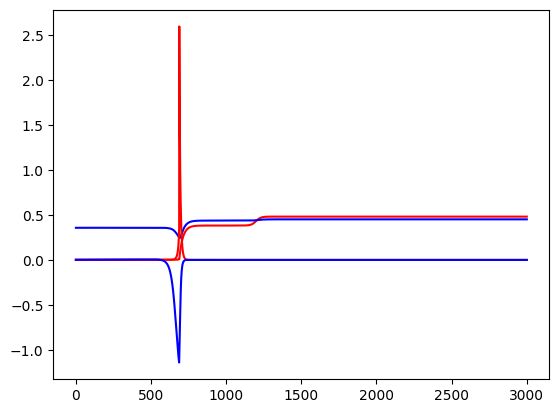

POINT  2
0.7384783475664028 14.93201621915232


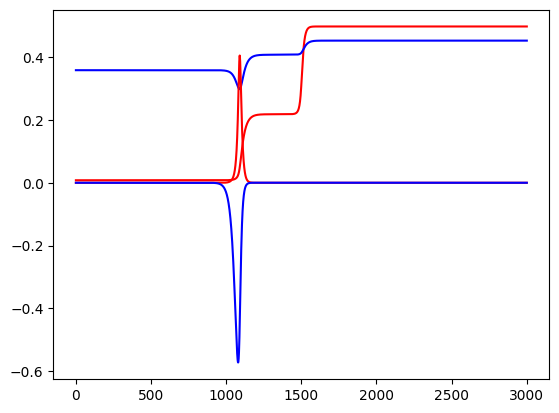

In [29]:
for i in range(len(points_bi)):
    print("POINT ", i+1)
    print(results_w2_du["cost"][i], results_w2_du["initial_cost"][i])
    plt.plot(results_w2_du["state"][i][0,0,:], color="red", linestyle='-')
    plt.plot(results_w2_du["state"][i][0,1,:], color="blue", linestyle='-')
    plt.plot(results_w2_du["control"][i][0,0,:], color="red")
    plt.plot(results_w2_du["control"][i][0,1,:], color="blue")
    plt.show()